In [1]:
import numpy as np
import pandas as pd
import time
import glob
import random
import copy
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34
from sklearn.model_selection import train_test_split
from LungXrayDataset import LungXrayDataset

In [2]:
train_images_normal = glob.glob('./dataset/chest_xray/train/NORMAL/*')
train_images_pneumonia = glob.glob('./dataset/chest_xray/train/PNEUMONIA/*')

In [3]:
test_images_normal = glob.glob('./dataset/chest_xray/test/NORMAL/*')
test_images_pneumonia = glob.glob('./dataset/chest_xray/test/PNEUMONIA/*')

In [4]:
train_images = train_images_normal + train_images_pneumonia

In [5]:
test_images = test_images_normal + test_images_pneumonia

In [6]:
train_images_labels = [0] * len(train_images_normal) + [1] * len(train_images_pneumonia)

In [7]:
test_images_labels = [0] * len(test_images_normal) + [1] * len(test_images_pneumonia)

In [8]:
print(len(train_images_labels), len(train_images))

5232 5232


In [9]:
print(len(test_images_labels), len(test_images))

624 624


In [10]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_images_labels, stratify=train_images_labels)

In [11]:
def show_random_images_RGB():
    image_normal = random.choice(train_images_normal)
    image_pneumoniia = random.choice(train_images_pneumonia)
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(Image.open(image_normal))
    ax1.set_title('Normal X-Ray Lung Image')
    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(Image.open(image_pneumoniia))
    ax2.set_title('Pneumonia X-Ray Lung Image')

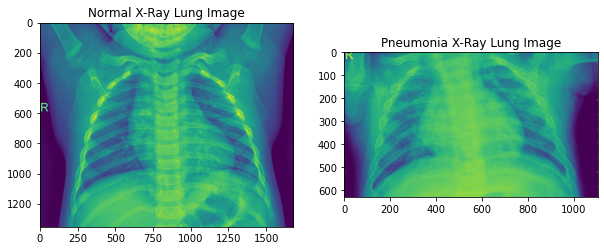

In [12]:
show_random_images_RGB()

In [13]:
def show_random_images_Gray():
    image_normal = random.choice(train_images_normal)
    image_pneumoniia = random.choice(train_images_pneumonia)
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(Image.open(image_normal).convert('LA'))
    ax1.set_title('Normal X-Ray Lung Image')
    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(Image.open(image_pneumoniia).convert('LA'))
    ax2.set_title('Pneumonia X-Ray Lung Image')

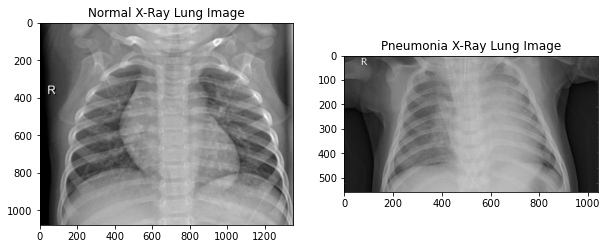

In [14]:
show_random_images_Gray()

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self, pretrained=True):
        super(NeuralNetwork, self).__init__()
        self.backbone = resnet18(pretrained=pretrained)
        self.fc = nn.Linear(in_features=512, out_features=1)
        
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        x = self.backbone.avgpool(x)
        x = x.view(x.size(0), 512)
        x = self.fc(x)
    
        return x
        

In [17]:
image_size = (500, 500)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.Resize(image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [18]:
train_dataset = LungXrayDataset(train_images, train_labels, train_transform)

In [19]:
val_dataset = LungXrayDataset(val_images, val_labels, test_transform)

In [24]:
pretrained = True

model = NeuralNetwork()

lr = 3e-3

num_epochs = 20
train_batch_size = 16
val_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, num_workers=5, shuffle=False)

dataloaders = {
    "train": train_dataloader,
    "val": val_dataloader
    
}

logging_steps = {
    "train": len(dataloaders["train"]) // 10,
    "val": len(dataloaders["val"]) // 10
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

batch_sizes = {
    "train": train_batch_size,
    "val": val_batch_size
}

criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [25]:
model.cuda()

NeuralNetwork(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [26]:
def train_model(model, criterion, optimizer, num_epochs, device="cuda"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    
    for epoch in tqdm(range(num_epochs), leave=False):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase]), leave=False, total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    predictions = output.sigmoid() > 0.5
                    loss = criterion(outputs, labels.float())
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
               
            
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if (i % logging_steps[phase] == 0) & (i > 0):
                    avg_loss = running_loss / ((i+1) * batch_sizes[phase])
                    avg_accuracy = running_corrects / ((i+1) * batch_sizes[phase])
                    
                    print(f"[{phase}]: {epoch+1} / {num_epochs} | loss: {avg_loss} | accuracy: {avg_accuracy}")
            
            epoch_loss = runnung_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects.double() / dataset_sizes[phases]
            
            print("{} Loss: :.4f Accuracy: {:.4f}" .format(phase, epoch_loss, epoch_accuracy))
            
            if phase == "val" and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()
        
    time_elapsed = time.time() - since
    
    print(f"Training took {time_elapsed} seconds")
    
    model.load_state_dict(best_model_wts)
    
    return model

In [27]:
model = train_model(model, criterion, optimizer, num_epochs)

  0%|                                                   | 0/246 [00:00<?, ?it/s]


RuntimeError: Expected one of cpu, cuda, xpu, mkldnn, opengl, opencl, ideep, hip, ve, ort, mlc, xla, lazy, vulkan, meta, hpu device type at start of device string: c

In [ ]:
save_path = 'model.pt'
torch.save(model.state_dict(), save_path)